In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
43069,NaN,NaN,International,2020-09-09,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43070,NaN,NaN,International,2020-09-10,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43071,NaN,NaN,International,2020-09-11,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


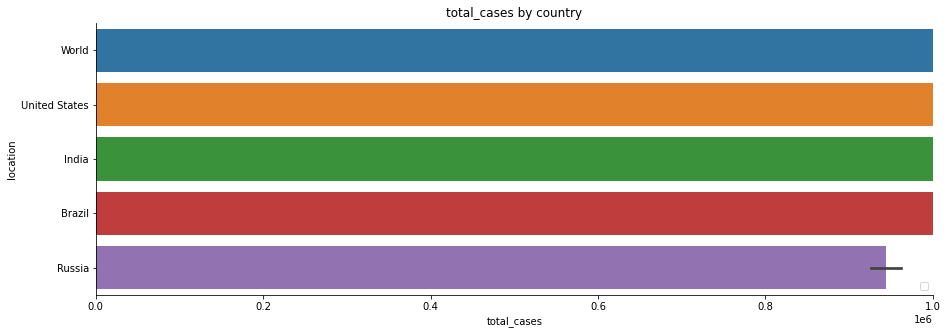

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


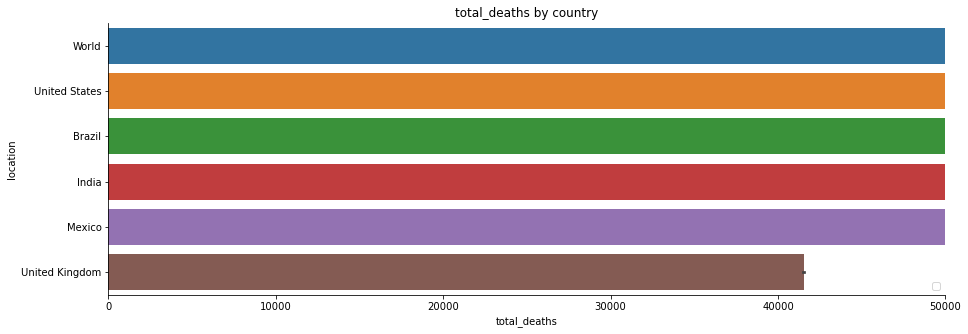

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


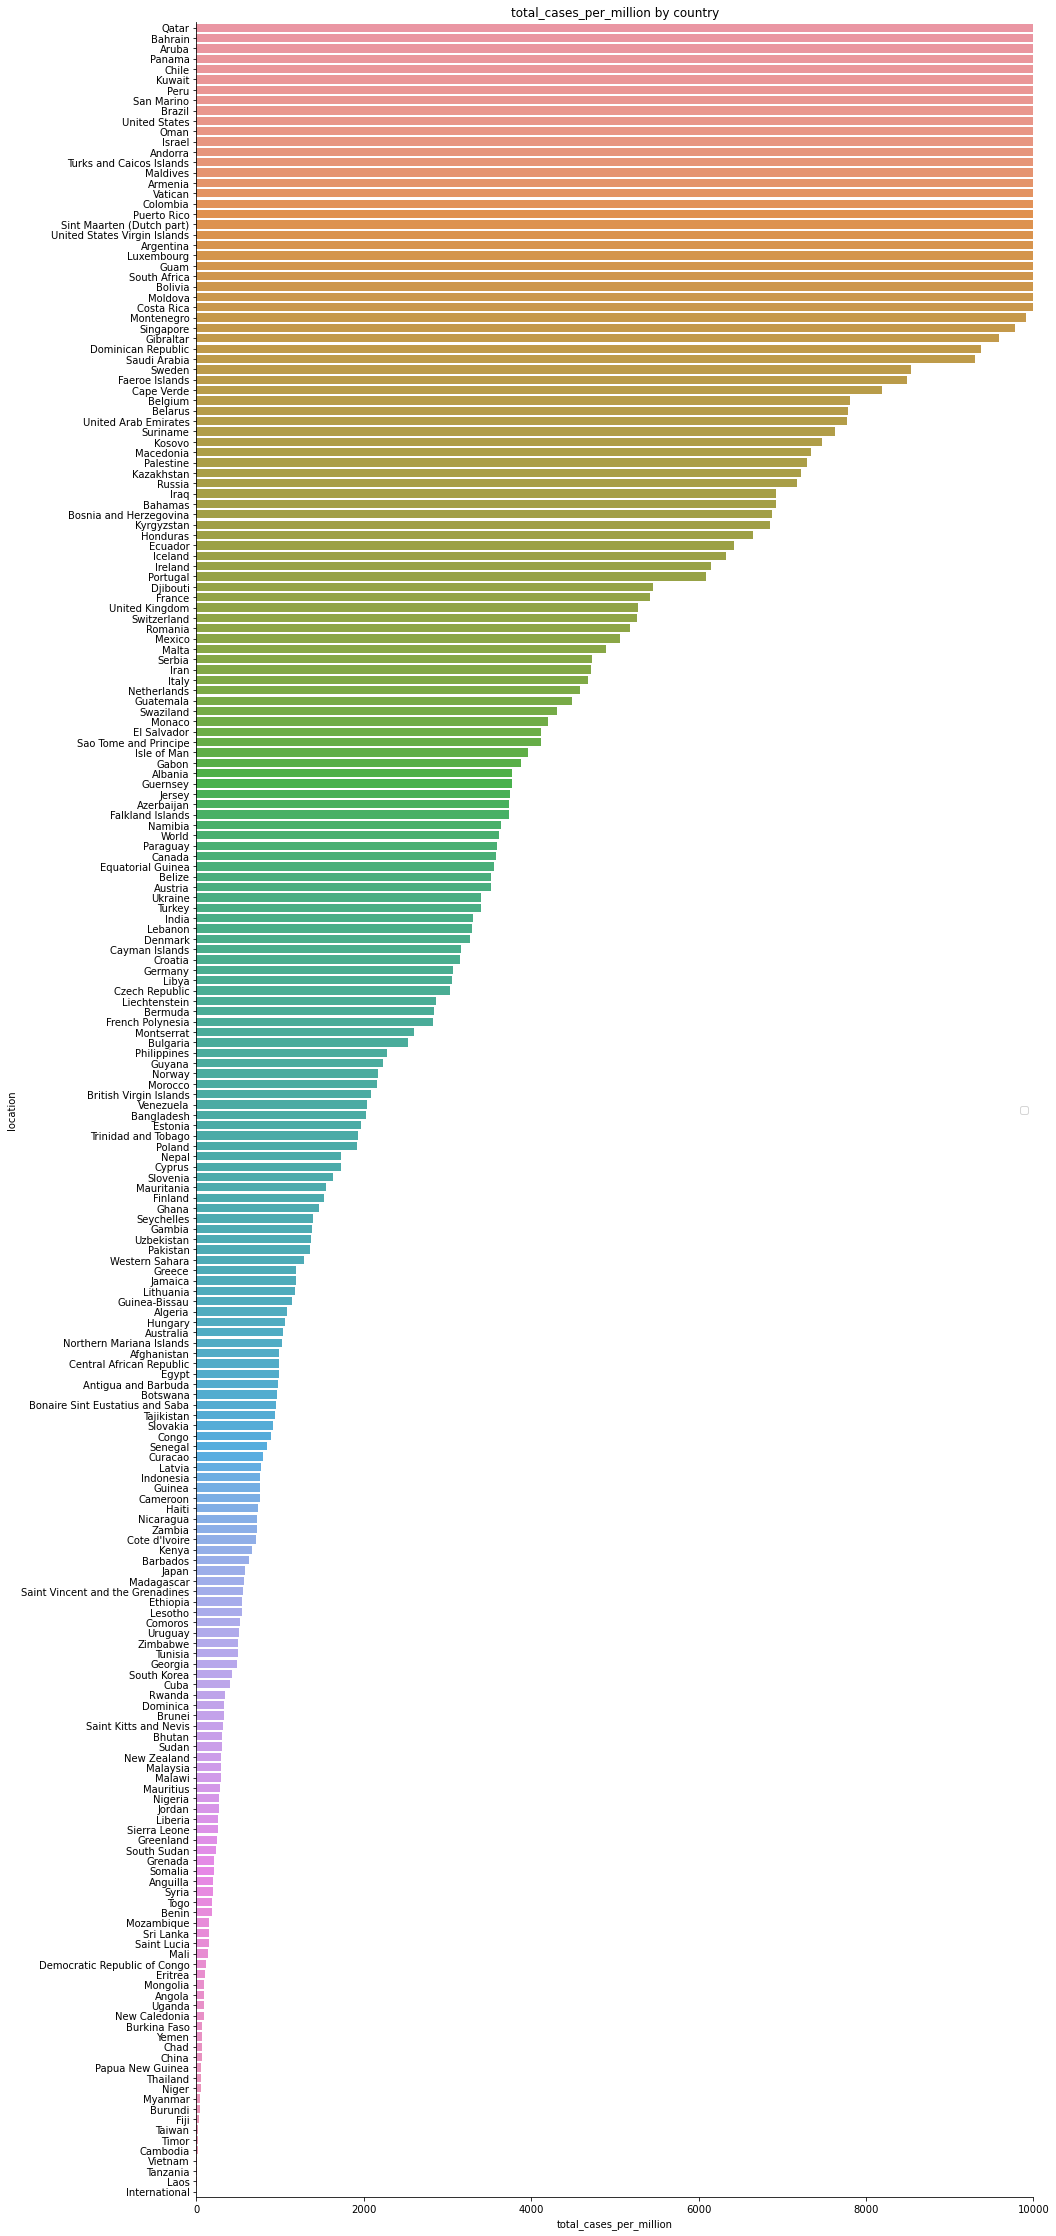

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


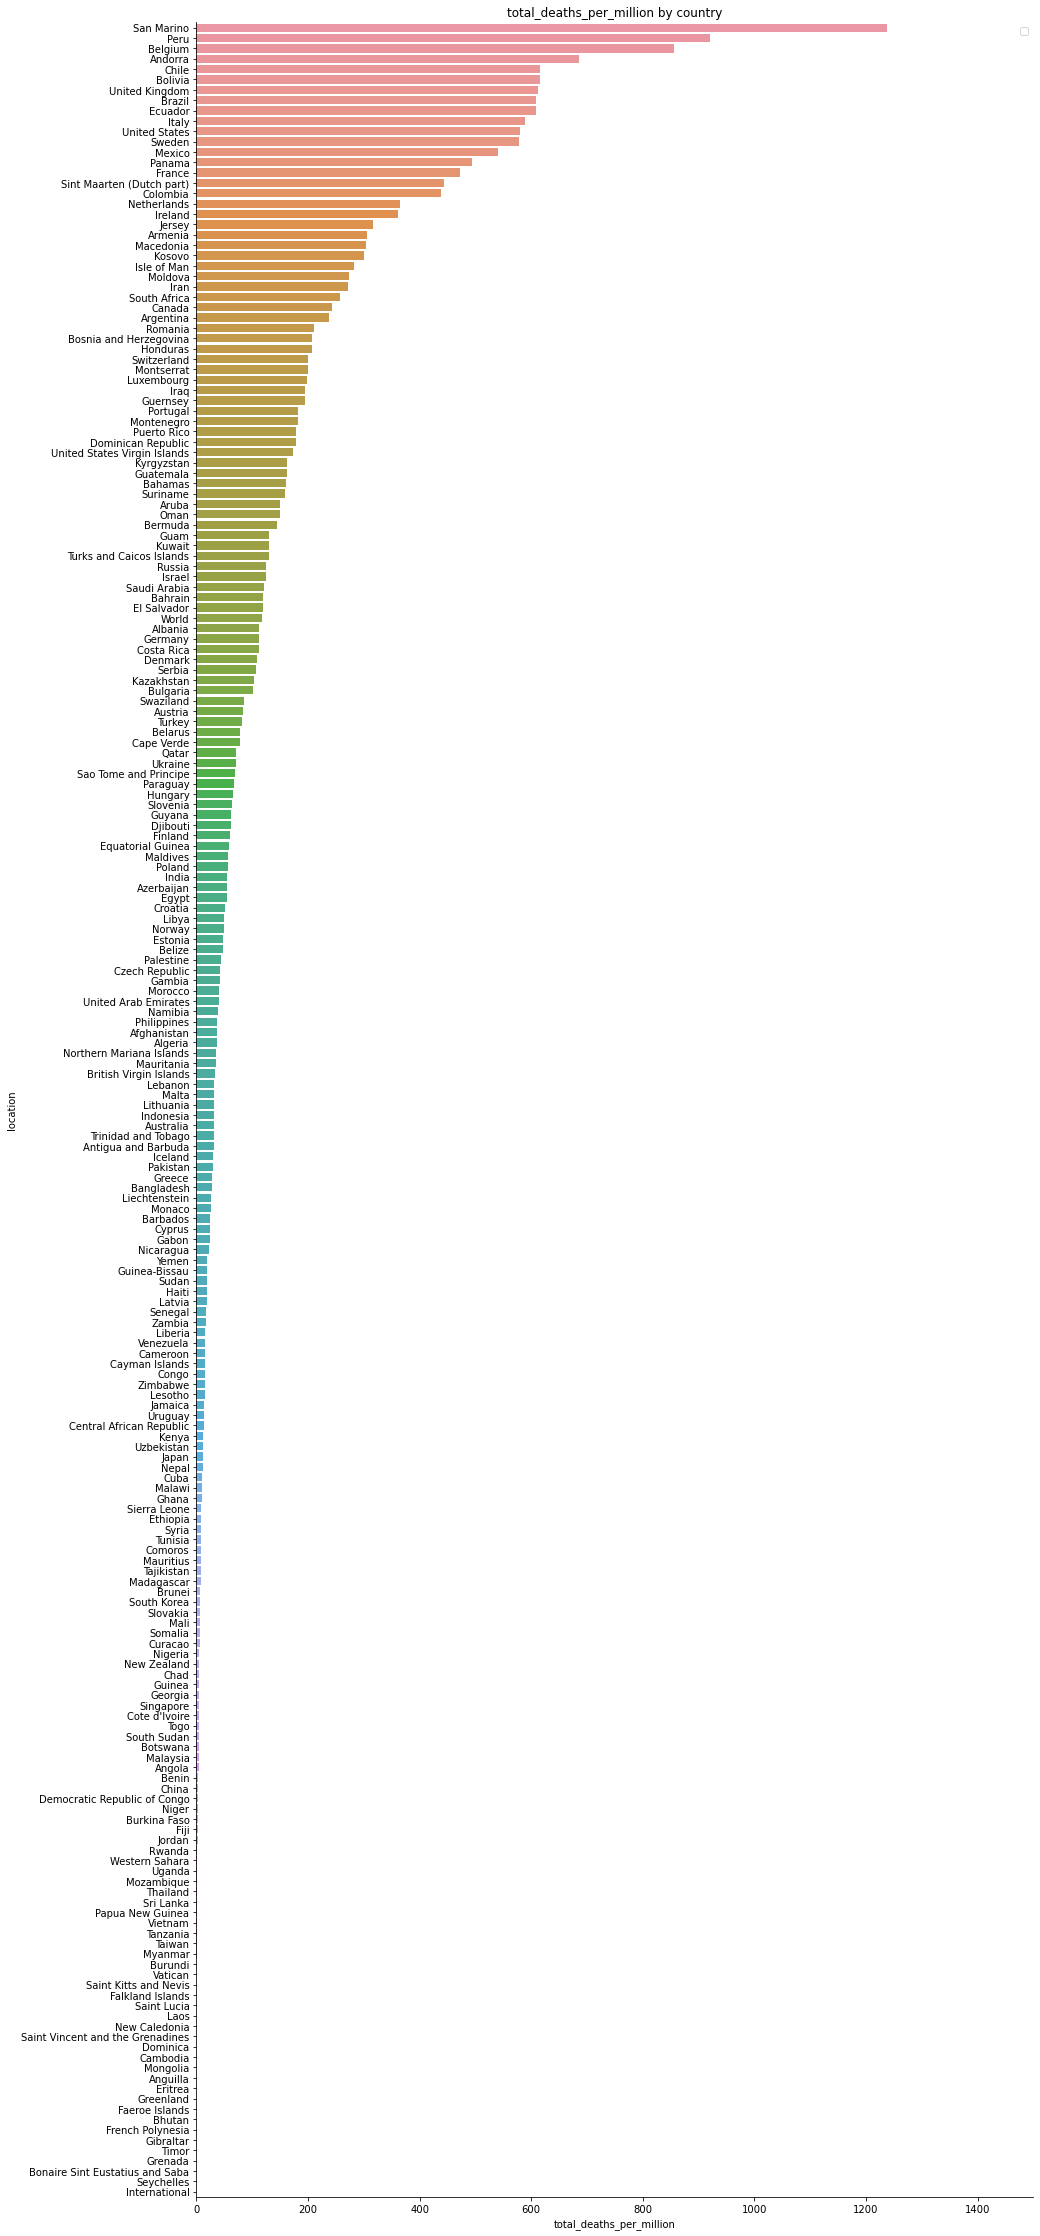

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

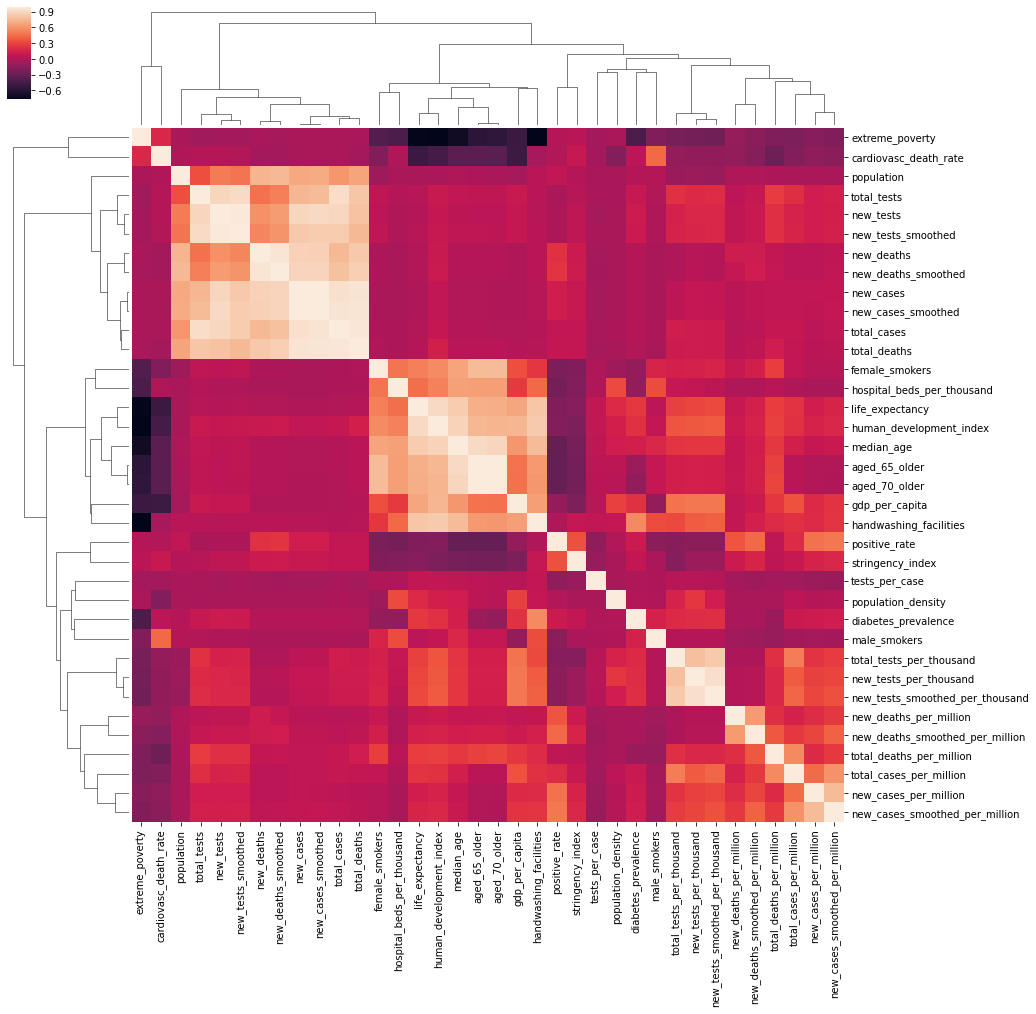

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9989998125528228 (+/- 0.0011296169652084131)
Coef :  [1.03397601e+00 9.33114293e-05 9.63085044e-05]
3 Last_days :  [[27621036 27902765 28199791]]
Today :  28199791
Prediction + :  459447
Tomorow :  28659238
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996377936540194 (+/- 0.00010503948513497018)
Coef :  [0.1412168  0.42191948 0.44719819]
3 Last_days :  [[898144 904078 910078]]
Today :  910078
Prediction + :  8134
Tomorow :  918212
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8727332580555061 (+/- 0.1746924364345663)
Coef :  [-0.74598076  0.77194624  0.97776259]
3 Last_days :  [[335524 344101 353944]]
Today :  353944
Prediction + :  7498
Tomorow :  361442
                                     
--------- Total Death -----------------
                                     
R^2: 0.8103486418939038 (+/- 0.2588120408808675)
Coef :  [-0.74984561  0.78870353  0.96012689]
3 Last_days :  [[30764 30794 30813]]
Today :  30813
Prediction + :  43
Tomorow :  30856
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.941312924903122 (+/- 0.049887331468976226)
Coef :  [-0.3274439  -0.01483803  1.33654775]
3 Last_days :  [[90087 90100 90127]]
Today :  90127
Prediction + :  24
Tomorow :  90151
                                     
--------- Total Death -----------------
                                     
R^2: -105.60294402010963 (+/- 150.649169523872)
Coef :  [-0.07730165  0.01245614  1.05665413]
3 Last_days :  [[4733 4733 4733]]
Today :  4733
Prediction + :  5
Tomorow :  4738
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9556695180096221 (+/- 0.06156876410192405)
Coef :  [-0.82017659  0.89637908  0.92316118]
3 Last_days :  [[280153 281583 283180]]
Today :  283180
Prediction + :  1262
Tomorow :  284442
                                     
--------- Total Death -----------------
                                     
R^2: 0.6638839304923184 (+/- 0.45089732425533446)
Coef :  [-0.82445052  0.89760122  0.92590743]
3 Last_days :  [[35563 35577 35587]]
Today :  35587
Prediction + :  31
Tomorow :  35618
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9716393149321197 (+/- 0.030800548600063524)
Coef :  [-0.38155473  0.21096843  1.17521814]
3 Last_days :  [[534513 543379 554143]]
Today :  554143
Prediction + :  7990
Tomorow :  562133
                                     
--------- Total Death -----------------
                                     
R^2: 0.018628054514716608 (+/- 1.1146678980224403)
Coef :  [-0.72811569  0.63458212  1.09253759]
3 Last_days :  [[29594 29628 29699]]
Today :  29699
Prediction + :  40
Tomorow :  29739
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9780848439089952 (+/- 0.030331433628822638)
Coef :  [0.06564604 0.4688597  0.4789201 ]
3 Last_days :  [[6327793 6359720 6397227]]
Today :  6397227
Prediction + :  79464
Tomorow :  6476691
                                     
--------- Total Death -----------------
                                     
R^2: 0.9963721913761846 (+/- 0.003608384509230125)
Coef :  [-0.47212879  0.70201799  0.77281272]
3 Last_days :  [[189679 190815 191789]]
Today :  191789
Prediction + :  1211
Tomorow :  193000
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9220614721591814 (+/- 0.10928595232886759)
Coef :  [-0.69738019  0.83671114  0.86111291]
3 Last_days :  [[352560 355219 358138]]
Today :  358138
Prediction + :  2174
Tomorow :  360312
                                     
--------- Total Death -----------------
                                     
R^2: 0.3178367498572526 (+/- 0.9210484865258319)
Coef :  [-0.76821178  0.83100399  0.93652744]
3 Last_days :  [[41586 41594 41608]]
Today :  41608
Prediction + :  40
Tomorow :  41648
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.881645409576512 (+/- 0.16621807887015858)
Coef :  [-0.78790751  0.85355969  0.93415918]
3 Last_days :  [[253474 255366 256850]]
Today :  256850
Prediction + :  1659
Tomorow :  258509
                                     
--------- Total Death -----------------
                                     
R^2: 0.32790467999288175 (+/- 0.9399269029991024)
Coef :  [-0.78776109  0.84013095  0.94688344]
3 Last_days :  [[9338 9341 9342]]
Today :  9342
Prediction + :  8
Tomorow :  9350
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: -5.8907125966516025 (+/- 9.743131805056521)
Coef :  [0.26578685 0.37373938 0.37121613]
3 Last_days :  [[391112 393425 395488]]
Today :  395488
Prediction + :  3813
Tomorow :  399301
                                     
--------- Total Death -----------------
                                     
R^2: 0.9619969984885196 (+/- 0.053167149526754325)
Coef :  [0.05602054 0.48217787 0.47278801]
3 Last_days :  [[22542 22669 22798]]
Today :  22798
Prediction + :  235
Tomorow :  23033
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9996197498114464 (+/- 0.0002960685210449235)
Coef :  [-0.69122043  0.82784986  0.86075887]
3 Last_days :  [[283270 284943 286455]]
Today :  286455
Prediction + :  1349
Tomorow :  287804
                                     
--------- Total Death -----------------
                                     
R^2: 0.999429232469128 (+/- 0.0003069757365233178)
Coef :  [-0.81237323  0.89353952  0.91649339]
3 Last_days :  [[6782 6837 6895]]
Today :  6895
Prediction + :  44
Tomorow :  6939
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6053632877394347 (+/- 0.5530798463507081)
Coef :  [-0.16913887  0.52416191  0.65841851]
3 Last_days :  [[4162073 4197889 4238446]]
Today :  4238446
Prediction + :  55763
Tomorow :  4294209
                                     
--------- Total Death -----------------
                                     
R^2: 0.4758807883769836 (+/- 0.7361513296290826)
Coef :  [-0.09303342  0.5137076   0.59042907]
3 Last_days :  [[127464 128539 129522]]
Today :  129522
Prediction + :  1418
Tomorow :  130940
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(28199791, 910078, 28659238, 918212),
 (353944, 30813, 361442, 30856),
 (283180, 35587, 284442, 35618),
 (554143, 29699, 562133, 29739),
 (6397227, 191789, 6476691, 193000),
 (90127, 4733, 90151, 4738),
 (358138, 41608, 360312, 41648),
 (256850, 9342, 258509, 9350),
 (395488, 22798, 399301, 23033),
 (286455, 6895, 287804, 6939),
 (4238446, 129522, 4294209, 130940)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-11,France,361442.0,0.0,30856.0,0.0,0.0,0.0
0,2020-09-11,China,90151.0,0.0,4738.0,0.0,0.0,0.0
0,2020-09-11,Italy,284442.0,0.0,35618.0,0.0,0.0,0.0
0,2020-09-11,Spain,562133.0,0.0,29739.0,0.0,0.0,0.0
0,2020-09-11,United States,6476691.0,0.0,193000.0,0.0,0.0,0.0
0,2020-09-11,World,28659238.0,0.0,918212.0,0.0,0.0,0.0
0,2020-09-11,United Kingdom,360312.0,0.0,41648.0,0.0,0.0,0.0
0,2020-09-11,Germany,258509.0,0.0,9350.0,0.0,0.0,0.0
0,2020-09-11,Iran,399301.0,0.0,23033.0,0.0,0.0,0.0
0,2020-09-11,Turkey,287804.0,0.0,6939.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")